# 1: Librerie
Importazione di tutte le librerie necessarie per la gestione del dataset, la costruzione del modello e l'apprendimento della rete.

* `tensorflow`: Funzioni di creazione del modello, e di gestione della fase di training.
* `numpy`: Gestione di array e funzioni di calcolo.
* `pandas`: Funzioni di apertura e parsing del dataset.
* `matplotlib`: Funzioni di gestione dei grafici, per la visualizzazione dei risultati in fase di training.

In [1]:
"""
Install dependencies:
>>> pip install --update pip
>>> pip install numpy pandas matplotlib seaborn scikit-learn tensorflow 
"""

'\nInstall dependencies:\n>>> pip install --update pip\n>>> pip install numpy pandas matplotlib seaborn scikit-learn tensorflow \n'

In [2]:
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers     as layers
import tensorflow.keras.models     as models
import pandas                      as pd
import numpy                       as np
import matplotlib.pyplot           as plt

from tensorflow.keras.callbacks            import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection               import train_test_split
from sklearn.preprocessing                 import LabelEncoder as le
from sklearn.metrics                       import confusion_matrix, ConfusionMatrixDisplay

2025-05-27 13:58:19.998023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 13:58:19.998805: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 13:58:20.003363: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 13:58:20.015973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748347100.037418  104742 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748347100.04

## Variabili globali
* `num_layers`: Configurazione degli strati della rete. Aggiungendo e rimuovendo neuroni, è possibile modificare la rete.
    * Ogni elemento di `num_layers` dovrebbe essere un array di 3 elementi: numero di neuroni nello strato, funzione di attivazione, larghezza del dropout.
* `num_epochs`: Numero di epoche di training del modello.
* `batch_size`: Larghezza dei batch durante la fase di training.

In [3]:
net_layers = [
    [32, 'relu', 0.1] for _ in range(2)] + [
    [64, 'relu', 0.1] for _ in range(5)] + [
    [32, 'relu', 0.1] for _ in range(2)
]
num_epochs = 100 # Number of epochs
batch_size = 16  # Batch size

# 2: Dataset augmentation function


In [4]:
def dataset_augmentation(dataset: pd.DataFrame, target_count = 1500, column_augmentation = ['Age', 'Old']) -> pd.DataFrame:

    col_key     = column_augmentation[0] # key column for filtering
    col_val     = column_augmentation[1] # value to filter by
    old_samples = dataset[dataset[col_key] == col_val].copy() # filter samples
    
    # check if there are any samples to augment
    if len(old_samples) == 0:
        print(f"WARNING: No samples found for {col_val} in column {col_key} for data augmentation.")
        return dataset
    
    # check if the number of samples is already sufficient
    if len(old_samples) >= target_count:
        print(f"WARNING: Number of samples for {col_val} in column {col_key} is already sufficient.")
        return dataset
    
    print(f"Target number of values for {col_val}: {target_count}")
    print(f"Number of samples found: {len(old_samples)}")

    num_cols = old_samples.keys()[1 : -1] # skip first and last column (not numeric features)
    
    synthetic_samples = []
    samples_needed    = target_count - len(old_samples)
    
    for i in range(samples_needed):

        base_sample = old_samples.sample(n = 1).iloc[0].copy() # base sample from 'Old' samples
        
        for col in num_cols: # add noise to numeric columns
            noise_factor     = np.random.uniform(0, 0.04)
            noise            = np.random.normal(0, base_sample[col] * noise_factor)
            base_sample[col] = max(0, base_sample[col] + noise) # ensure no negative values
        
        synthetic_samples.append(base_sample) # append modified sample to list
    
    # convert list of synthetic samples to DataFrame
    synthetic_df      = pd.DataFrame(synthetic_samples)
    augmented_dataset = pd.concat([dataset, synthetic_df], ignore_index = True)
    
    print(f"Number of samples after augmentation: {len(augmented_dataset)}")
    
    return augmented_dataset # return augmented dataset with synthetic samples

# 3: Dataset
Importazione del dataset e divisione delle istanze per validation, training e testing.

## Obiettivo del modello
Classificazione dell'età di un *abalone*, a seconda delle misure fisiche effettuate.

* Elementi: **4177** istanze, **5641** dopo  l'augmentation
* Features disponibili: **8** colonne
* Classificazione: **3** classi

In [5]:
try:

    dataset = pd.read_csv("./Shuffled_Dataset.csv") # load the dataset
    dataset['Sex'] = le().fit_transform(dataset['Sex']) # label encoding for column 'Sex'
    """
    for val in dataset['Age'].unique(): # Dataset augmentation
        dataset = dataset_augmentation(dataset, target_count = 1500, column_augmentation = ['Age', val]) 
    """
    # One-hot encoding for column 'Age'
    column     = 'Age'
    dataset    = pd.get_dummies(dataset, columns = [column], prefix = column)
    dummy_cols = [col for col in dataset.columns if col.startswith(f'{column}_')]

    # Separate features and labels
    Y = dataset[dummy_cols]
    X = dataset.drop(columns = dummy_cols)

    # First split: 70% train, 30% combined validation and test
    X_train, X_comb, Y_train, Y_comb = train_test_split(X, Y, test_size = 0.3, random_state = 42)

    # Second split: 65% validation, 35% test from the combined set
    X_val, X_test, Y_val, Y_test = train_test_split(X_comb, Y_comb, test_size = 0.35, random_state = 42)

    print("\nTraining set shape:  ", X_train.shape, Y_train.shape)
    print("Validation set shape:", X_val.shape, Y_val.shape)
    print("Test set shape:      ", X_test.shape, Y_test.shape)
except FileNotFoundError:
    print("ERROR: Dataset file not found. Please ensure the file 'Dataset.csv' is in the current directory.")


Training set shape:   (3220, 8) (3220, 3)
Validation set shape: (897, 8) (897, 3)
Test set shape:       (483, 8) (483, 3)


# 4: Creazione del modello
Generazione di un modello di rete neurale.

In [18]:
model = models.Sequential([layers.Input(shape = (X_train.shape[1],))]) # Input layer

for layer in net_layers: # Add hidden layers
    model.add(layers.Dense(layer[0], activation = layer[1])) # Dense layer
    model.add(layers.Dropout(layer[2])) # Dropout layer to prevent overfitting
    model.add(layers.BatchNormalization()) # Batch normalization layer
    
model.add(layers.Dense(Y_train.shape[1], activation = 'softmax')) # Output layer

model.summary() # Print the model summary

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,123 (98.14 KB)

 Trainable params: 24,227 (94.64 KB)

 Non-trainable params: 896 (3.50 KB)

## 5: Compilazione e training del modello generato

In [19]:
lr_schedule = ExponentialDecay(
    initial_learning_rate = 0.001, # Starting learning rate
    decay_steps           = 2e3, # Number of steps before decay
    decay_rate            = 0.9, # Multiplicative decay factor
)

model.compile(
    optimizer = optimizers.Adam(learning_rate = lr_schedule),
    loss      = 'categorical_crossentropy', 
    metrics   = ['accuracy', 'Precision', 'Recall']
)

early_stop = EarlyStopping(
    monitor              = 'val_loss',
    patience             = 10,
    restore_best_weights = True,
    min_delta            = 0.001,
    verbose              = 1
 )

In [20]:
history = model.fit(
    X_train, Y_train,
    epochs          = num_epochs,     # Number of epochs
    shuffle         = True,           # Shuffle the data
    batch_size      = batch_size,     # Batch size
    validation_data = (X_val, Y_val), # Validation data
    callbacks       = [early_stop]    # Callback for LR reduction
)

Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - Precision: 0.4526 - Recall: 0.3490 - accuracy: 0.4254 - loss: 1.2798 - val_Precision: 0.5262 - val_Recall: 0.3813 - val_accuracy: 0.5619 - val_loss: 0.9363
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - Precision: 0.6071 - Recall: 0.4641 - accuracy: 0.5654 - loss: 0.9471 - val_Precision: 0.6997 - val_Recall: 0.4571 - val_accuracy: 0.5987 - val_loss: 0.8123
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - Precision: 0.6341 - Recall: 0.5104 - accuracy: 0.6059 - loss: 0.8706 - val_Precision: 0.7137 - val_Recall: 0.5697 - val_accuracy: 0.6366 - val_loss: 0.7736
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - Precision: 0.6411 - Recall: 0.5208 - accuracy: 0.6097 - loss: 0.8332 - val_Precision: 0.6739 - val_Recall: 0.5162 - val_accuracy: 0.6254 - val_loss: 0.7574
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - Precision: 0.6299 - Recall: 0.5335 - accuracy: 0.6000 - loss: 0.8122 - val_Precision: 0.7160 - v

## 6: Visualizzazione dei risultati

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.8380 - Recall: 0.8367 - accuracy: 0.8367 - loss: 0.4200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Test set evaluation:
Precision: 0.8174
Recall:    0.8157
Loss:      0.4375
Accuracy:  0.8157
F1-score:  0.8166


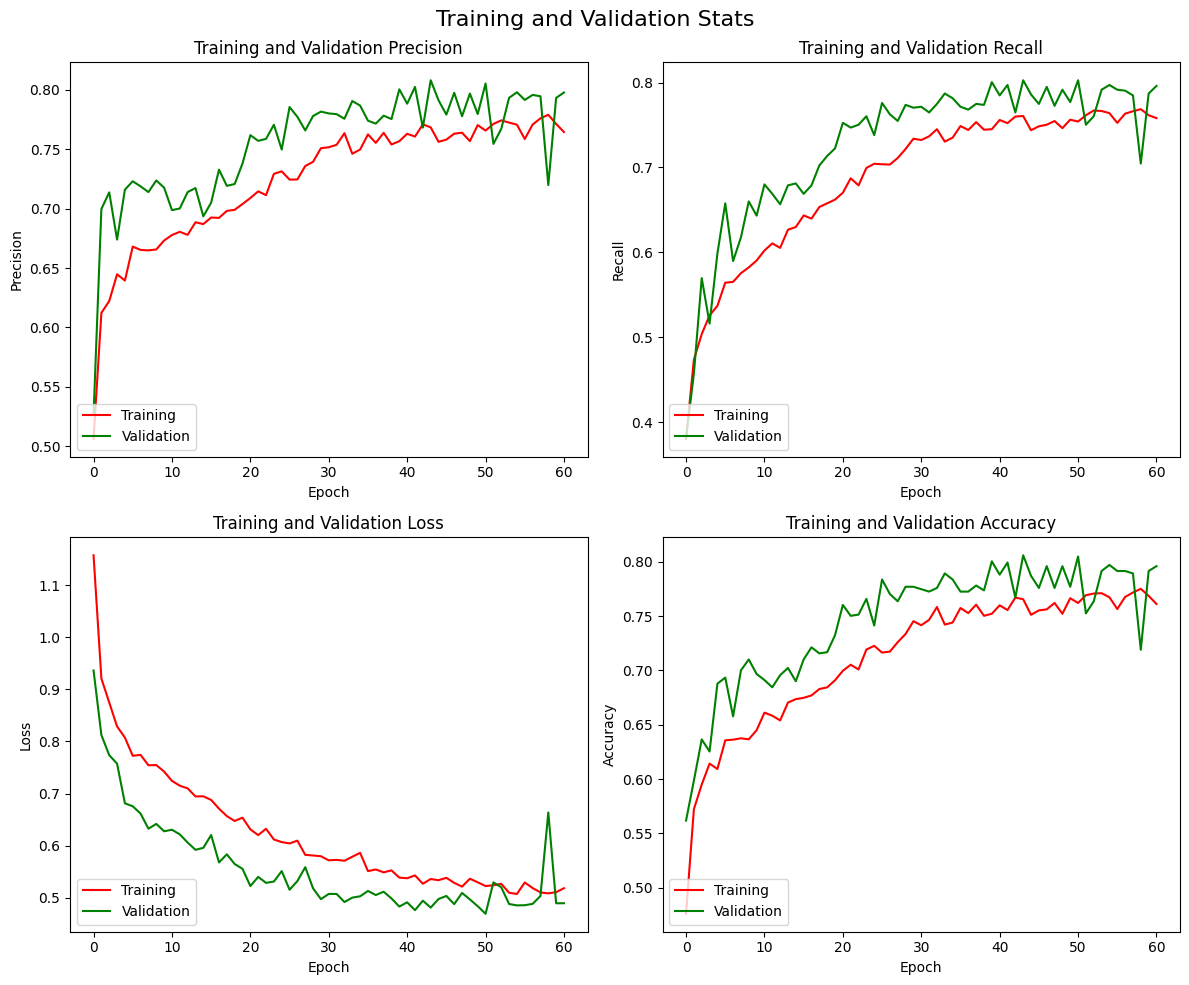

Text(0.5, 1.0, 'Confusion Matrix')

<Figure size 800x600 with 0 Axes>

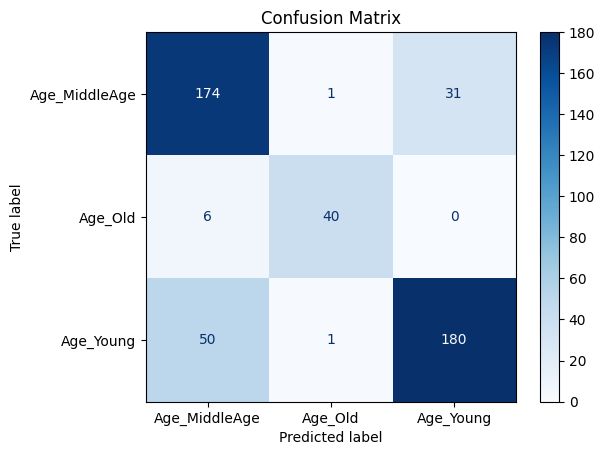

In [21]:
eval = model.evaluate(X_test, Y_test, return_dict = True) # Evaluate the model on the test set

y_pred = model.predict(X_test) # Predict on the test set
y_pred_classes = np.argmax(y_pred, axis = 1) # Get predicted classes
y_true_classes = np.argmax(Y_test.values, axis = 1) # Get true classes
cm = confusion_matrix(y_true_classes, y_pred_classes) # Compute confusion matrix

print("Test set evaluation:")
print(f"Precision: {eval['Precision']:.4f}")
print(f"Recall:    {eval['Recall']:.4f}")
print(f"Loss:      {eval['loss']:.4f}")
print(f"Accuracy:  {eval['accuracy']:.4f}")
print(f"F1-score:  {2 * (eval['Precision'] * eval['Recall']) / (eval['Precision'] + eval['Recall']):.4f}")

fig, plots = plt.subplots(2, 2, figsize = (12, 10)) # Create a figure with 2 subplots
fig.suptitle('Training and Validation Stats', fontsize = 16)

# Training and validation precision
plots[0, 0].set_title('Training and Validation Precision') # Set title for the first subplot
plots[0, 0].plot(history.history['Precision'],     label = 'Training',   color = 'red')   # plot 1
plots[0, 0].plot(history.history['val_Precision'], label = 'Validation', color = 'green') # plot 2
plots[0, 0].set_ylabel('Precision') # Set y-axis label
plots[0, 0].legend(loc = 'lower left') # add legend to the plot in lower left corner

# Training and validation recall
plots[0, 1].set_title('Training and Validation Recall') # Set title for the second subplot
plots[0, 1].plot(history.history['Recall'],     label = 'Training',   color = 'red')   # plot 1
plots[0, 1].plot(history.history['val_Recall'], label = 'Validation', color = 'green') # plot 2
plots[0, 1].set_ylabel('Recall') # Set y-axis label
plots[0, 1].legend(loc = 'lower left') # add legend to the plot in lower left corner

# Training and validation loss
plots[1, 0].set_title('Training and Validation Loss') # Set title for the third subplot
plots[1, 0].plot(history.history['loss'],     label = 'Training',   color = 'red')   # plot 1
plots[1, 0].plot(history.history['val_loss'], label = 'Validation', color = 'green') # plot 2
plots[1, 0].set_ylabel('Loss')  # Set y-axis label
plots[1, 0].legend(loc = 'lower left') # add legend to the plot in lower left corner

# Training and validation accuracy
plots[1, 1].set_title('Training and Validation Accuracy') # Set title for the fourth subplot
plots[1, 1].plot(history.history['accuracy'],     label = 'Training',   color = 'red')   # plot 1
plots[1, 1].plot(history.history['val_accuracy'], label = 'Validation', color = 'green') # plot 2
plots[1, 1].set_ylabel('Accuracy') # Set y-axis label
plots[1, 1].legend(loc = 'lower left') # add legend to the plot in lower left corner

for plot in plots.flat:
    plot.set_xlabel('Epoch') # Set x-axis label in all subplots

fig.tight_layout() # Adjust layout to prevent overlap
plt.show()         # Show the plots

plt.figure(figsize = (8, 6)) # Create a new figure for the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Y.columns) 
cm_display.plot(cmap = 'Blues') # Plot confusion matrix on the last subplot
plt.title('Confusion Matrix') # Set title for the confusion matrix subplot